# This is an overview of the SiRCle pipeline performed on ccRCC

## 1. Data pre-processing

After getting the matrix of data for gene expression, DNA methylation and protein data first we need to ensure that the data are of high quality.

1. Filter out patients with a low correlation in each dataset, check that tumour and normal separate via PCA/heigherarchical clustering.
2. Save samples to csv for DE, DA, dCpG analysis.


## 2. Differential Analysis (R)

1. Perform DE, DA, and dCpG analysis for each of the datasets.

## 3. SiRCle 

1. Summarise differential CpGs to genes.  
2. Plot volcano of each differential analysis.  
3. Run SiRCle using the DE/DA/dCpG results.  

## 4. Over representation analysis (R)

1. Run ORA on each of the SiRCle clusters. 

## 5. Visualise ORA

1. Visualise ORA results as EMAP plots  

## 6. Test metabolic pathway dysregulation (R)
1.  Test metabolic pathway dysregulation for differential pathways

## 7. Differential gene analysis between patient subsets

1. Compare Stage 1 vs Stage 4, old vs young, and man vs woman using DE, dCpG, DA
2. Compare Stage 1 vs Stage 4, old vs young, and man vs woman using DE, dCpG, VAE
3. Perform GSEA on VAE & DE, dCpG and DA results

## 8. Cell specificity gene set testing

1. Using genes from 6.2 test for cell type specificity in single cell kideny cancer data

## Data notes prior to starting:

### Supplementary file requirements (provided at zotero XXX):
a. `hsapiens_gene_ensembl-GRCh38.p13.csv` --> this can be created for different species, or for different builds using scibiomart (`https://github.com/ArianeMora/scibiomart`) but we provide the file for hg38.  
b. `infinium-methylationepic-v-1-0-b5-manifest-file.csv` --> manifest file downloaded from: https://sapac.support.illumina.com/downloads/infinium-methylationepic-v1-0-product-files.html

### Data required for the input (examples for ccRCC provided at zotero):
a. RNAseq matrix, columns as the patient samples, rows as the genes, using the gene name as the ID
b. CpG matirx, columns as patient samples, rows as the CpGs (expecting probes), using the probe ID as the ID
c. Protein matrix, columns as patient samples, rows as the gene names associated with the proteins.

Each one requires a sample file with the following columns:
1. SafeCases: patient identifier
2. CondID: 1 = Tumour, 0 = Normal
3. SampleType: Tumour, Normal
4. FullLabel: Column name in the associated matrix file.
5. Optional: any patient attributes interested in investigating or sample specific attributes.
The optional ones we used were: Age, TumorStage, Race, Gender

In [25]:
# Imports
import pandas as pd
from sciviso import *
from scircm import * # Note if you have a mac M1 use from sircle import * and you won't be able to do 7,8
import seaborn as sns
import numpy as np
from sciutil import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

u = SciUtil()
data_dir = '../ccRCC/'
input_dir = '../ccRCC/data_input/'
output_dir = '../ccRCC/data_input/'
supp_dir = '../supps/'
fig_dir = '../figs/'

In [26]:
rna_data = pd.read_csv(f'{output_dir}data_RNA.csv')
cpg_data = pd.read_csv(f'{output_dir}data_CpG.csv')

rna_samples = pd.read_csv(f'{output_dir}samples_RNA.csv')
cpg_samples = pd.read_csv(f'{output_dir}samples_CpG.csv')


In [88]:
protein_data = pd.read_csv(f'{output_dir}data_protein.csv')
protein_samples = pd.read_csv(f'{output_dir}samples_protein.csv')


In [89]:
protein_samples

,SafeCases,CondID,SampleType,FullLabel,Age,ajcc_pathologic_stage,race,gender
0,C3L.01287,0,Normal,C3L.01287_Normal,old,Stage IV,white,male
1,C3L.00561,0,Normal,C3L.00561_Normal,middle,Stage III,white,male
2,C3L.00561,1,Tumor,C3L.00561_Tumor,middle,Stage III,white,male
3,C3L.01287,1,Tumor,C3L.01287_Tumor,old,Stage IV,white,male
4,C3L.01603,1,Tumor,C3L.01603_Tumor,old,Stage I,white,male
...,...,...,...,...,...,...,...,...
180,C3N.00494,1,Tumor,C3N.00494_Tumor,old,Stage I,NaN,male
181,C3N.00390,1,Tumor,C3N.00390_Tumor,middle,Stage IV,NaN,male
182,C3N.00312,0,Normal,C3N.00312_Normal,old,Stage III,NaN,male
183,C3N.00494,0,Normal,C3N.00494_Normal,old,Stage I,NaN,male


## 1. Filter out patients with a low correlation in each dataset, check that tumour and normal separate via PCA/heigherarchical clustering.


In [27]:
  
def run_methylation_qc(sample_df, merged, label):
    u.dp([label, 'Normal', len(sample_df[sample_df['SampleType'] == 'Normal']), 
          'Tumor', len(sample_df[sample_df['SampleType'] == 'Tumor'])])
    
    #merged.set_index('id', inplace=True)
    merged['Locus'] = merged.index

    merged = merged.fillna(0)
    merged = merged.replace(1.0, 0.99)
    merged = merged.replace(0.0, 0.01)
    cols = sample_df.FullLabel.values
    colour = ['blue' if c == 'Normal' else 'red' for c in sample_df.SampleType.values]
    # Do a PCA of everything before filtering
    vals = merged[cols].values.T
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_

    plt.rcParams['figure.figsize'] = [4, 4]
    plt.scatter(pca_values[:, 0], pca_values[:, 1], c=colour, s=100, alpha=0.5)
    plt.title(f'{label} PCA VAR: 0: {var_ratio[0]}, 1: {var_ratio[1]}')
    plt.show()

    mean_cpg = np.mean(merged[cols].values, axis=1)
    plt.hist(mean_cpg)
    plt.title(f'Raw mean CpG {label} no. {len(merged)}')
    plt.show()

    merged = merged[mean_cpg > 0.05]
    mean_cpg = np.mean(merged[cols].values, axis=1)
    merged = merged[mean_cpg < 0.95]

    var_df = np.var(merged[cols].values, axis=1)
    plt.hist(var_df)
    plt.title(f'Filtered CpG variance')
    plt.show()

    # Filter genes to have unique gene names keeping the one with the highest variance
    merged['var'] = var_df
    merged.sort_values(['Locus', 'var'], ascending=False, inplace=True)
    merged.drop_duplicates(subset='Locus', keep='first', inplace=True)
    merged = merged[merged['var'] > 0]  # Drop those with 0 variance
    merged = merged.drop(columns=['var'])
    
    var_cpg = np.var(merged[cols].values, axis=1)
    plt.hist(var_cpg)
    plt.title(f'Filtered CpG variance {label}')
    plt.show()

    mean_cpg = np.mean(merged[cols].values, axis=1)
    plt.hist(mean_cpg)
    plt.title(f'Filtered mean CpG {label} no. {len(merged)}')
    plt.show()

    corr = merged[cols].corr()
    sns.clustermap(corr, 
                xticklabels=sample_df['SampleType'].values,
                yticklabels=sample_df['SampleType'].values, cmap='RdBu_r', row_cluster=True, col_cluster=True)
    plt.title(f'{label} correlation {min(np.min(corr))}')
    plt.show()

    # Print out the minimum correlation:
    mean_cor = np.mean(corr, axis=1)
    corr['mean_corr'] = mean_cor
    corr.sort_values(by=['mean_corr'])
    # Plot out the mean correlation values so we can choose a good filter.
    plt.hist(mean_cor, bins=20)
    plt.title(f'{label} min corr: {min(np.min(corr))}')

    # Filter the shitty patients
    corr_sorted = corr.sort_values(by=['mean_corr'])
    corr_sorted = corr_sorted[corr_sorted['mean_corr'] < 0.8]
    u.dp([len(corr_sorted), 'patients with avg. correlations less than 50%. Filtering out these samples, and printing cases.'])

    cols_to_omit = [c for c in corr_sorted.index]
    print('\n'.join(cols_to_omit))
    cols_to_keep = [c for c in merged.columns if c not in cols_to_omit]
    cpg_filtered = merged[cols_to_keep]

    # Fill NAs with 0's
    cpg_filtered = cpg_filtered.fillna(0)
    # Filter sample df to only include those samples
    sample_df = sample_df[sample_df['FullLabel'].isin(cols_to_keep)]

    # Have a look at the new PCA
    cols = sample_df.FullLabel.values
    colour = ['blue' if c == 'Normal' else 'red' for c in sample_df.SampleType.values]

    vals = cpg_filtered[cols].values.T
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_

    plt.rcParams['figure.figsize'] = [4, 4]
    plt.scatter(pca_values[:, 0], pca_values[:, 1], c=colour, s=100, alpha=0.5)
    plt.title(f'Filtered {label} PCA VAR: 0: {var_ratio[0]}, 1: {var_ratio[1]}')
    plt.show()
    
    sample_df.to_csv(f'{output_dir}samples_{label}.csv', index=False)
    cpg_filtered.to_csv(f'{output_dir}data_{label}.csv', index=False)
    return sample_df, cpg_filtered

In [28]:
def plot_figure1(df, sample_df, label, log2_transform=False):
    ## Now we want to do a PCA of the RNAseq and also the DNA methylation values

    sample_to_stage = dict(zip(sample_df.FullLabel, sample_df.ajcc_pathologic_stage))
    sample_to_type = dict(zip(sample_df.FullLabel, sample_df.SampleType))
    sample_to_age = dict(zip(sample_df.FullLabel, sample_df.Age))
    sample_to_race = dict(zip(sample_df.FullLabel, sample_df.race))
    sample_to_gender = dict(zip(sample_df.FullLabel, sample_df.gender))

    # Need some colour maps 
    stage_colours = {
                    'Stage I': '#0f2939',
                    'Stage III': '#82bd84',
                    'Stage IV': '#bdd886', 
                    'Stage II': '#ff7c43'}

    type_colours = {'Normal': '#94f8e5',
                    'Tumor': '#cd4556'}

    age_colours = {'old': '#003c58',
                   'young': '#f85c69',
                   'middle': '#094555',
                  None: 'grey'}

    race_colours = {'white': '#d24f85',
                   'black or african american': '#ffef90',
                    'not reported': 'grey',
                   }
    
    
    corr = df[sample_df['FullLabel'].values].corr()

    s_colour = [stage_colours.get(sample_to_stage.get(c)) if stage_colours.get(sample_to_stage.get(c)) else 'grey' for c in sample_df.FullLabel.values]
    a_colour = [age_colours.get(sample_to_age.get(c)) if age_colours.get(sample_to_age.get(c)) else 'grey' for c in sample_df.FullLabel.values]
    r_colour = [race_colours.get(sample_to_race.get(c)) if race_colours.get(sample_to_race.get(c)) else 'grey' for c in sample_df.FullLabel.values]
    t_colour = [type_colours.get(sample_to_type.get(c)) if type_colours.get(sample_to_type.get(c)) else 'grey' for c in sample_df.FullLabel.values]

    row_colours = [s_colour, a_colour, r_colour, t_colour]
    corr.columns = sample_df['SampleType'].values
    corr.index = sample_df['Age'].values
    sns.clustermap(corr,
                   cmap='RdBu_r', row_colors=row_colours,
                   row_cluster=True, col_cluster=True)
    plt.title(f'{label} Filtered correlation {min(np.min(corr))}')
    plt.savefig(f'{fig_dir}Figure1A_{label}.svg')
    plt.show()

    cols = sample_df.FullLabel.values
    colour = [type_colours.get(c) if type_colours.get(c) else 'grey' for c in sample_df.SampleType.values]

    vals = df[cols].values.T
    if log2_transform:
        vals = np.log2(vals + 1)
        
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_

    plt.rcParams['figure.figsize'] = [2, 2]
    fig, ax = plt.subplots()
    ax.scatter(pca_values[:, 0], pca_values[:, 1], c=colour, s=30, alpha=0.8)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    plt.title(f'{label} samples')
    plt.xlabel(f'PC1 ({int(var_ratio[0]*100)}%)')
    plt.ylabel(f'PC2 ({int(var_ratio[1]*100)}%)')
    plt.savefig(f'../figs/Figure1A_PCA_{label}.svg')

    plt.show()

In [102]:

def run_protein_qc(sample_df, merged, label):

    u.dp([label, 'Normal', len(sample_df[sample_df['SampleType'] == 'Normal']), 
          'Tumor', len(sample_df[sample_df['SampleType'] == 'Tumor'])])
    
    print('Number of Genes prior to filtering: ', len(merged))
    
    cols = list(sample_df.FullLabel.values)
    # Normalise
    merged.replace(0, np.nan, inplace=True)
    merged = merged[~merged['gene_name'].isin(['Mean', 'StdDev', 'Median'])]
    merged.set_index('gene_name', inplace=True)
    merged = merged.apply(lambda row: row.fillna(row.mean()), axis=1)
    merged.reset_index(inplace=True)
    colour = ['blue' if c == 'Normal' else 'red' for c in sample_df.SampleType.values]
    # Do a PCA of everything before filtering
    vals = merged[cols].values.T
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_

    plt.rcParams['figure.figsize'] = [4, 4]
    plt.scatter(pca_values[:, 0], pca_values[:, 1], c=colour, s=100, alpha=0.5)
    plt.title(f'{label} PCA VAR: 0: {var_ratio[0]}, 1: {var_ratio[1]}')
    plt.show()

    mean_rna = np.mean(merged[cols].values, axis=1)
    plt.hist(mean_rna)
    plt.title(f'Raw mean protein {label} no. {len(merged)}')
    plt.show()

    mean_rna = abs(np.mean(merged[cols].values, axis=1))
    merged = merged[mean_rna > 0.05]
    
    var_rna = np.var(merged[cols].values, axis=1)
    plt.hist(var_rna)
    plt.title(f'Filtered protein variance')
    plt.show()

    # Filter genes to have unique gene names keeping the one with the highest variance
    merged['var'] = var_rna
    merged.sort_values(['gene_name', 'var'], ascending=False, inplace=True)
    merged.drop_duplicates(subset='gene_name', keep='first', inplace=True)
    merged = merged[merged['var'] > 0]  # Drop those with 0 variance
    print(len(merged))
    mean_df = np.mean(merged[cols].values, axis=1)
    plt.hist(mean_df)
    plt.title(f'Filtered mean protein {label} no. {len(merged)}')
    plt.show()

    corr = merged[cols].corr()
    # Print out the minimum correlation:
    mean_cor = np.mean(corr, axis=1)
    corr['mean_corr'] = mean_cor
    corr.sort_values(by=['mean_corr'])
    # Plot out the mean correlation values so we can choose a good filter.
    plt.hist(mean_cor, bins=20)
    plt.title(f'{label} min corr: {min(np.min(corr))}')

    # Filter the shitty patients
    corr_sorted = corr.sort_values(by=['mean_corr'])
    corr_sorted = corr_sorted[corr_sorted['mean_corr'] < -0.3]
    u.dp([len(corr_sorted), 'patients with avg. correlations less than 50%. Filtering out these samples, and printing cases.'])

    cols_to_omit = [c for c in corr_sorted.index]
    print('\n'.join(cols_to_omit))
    cols_to_keep = [c for c in merged.columns if c not in cols_to_omit]
    df_filtered = merged[cols_to_keep]

    # Fill NAs with 0's
    df_filtered = df_filtered.fillna(0)
    # Filter sample df to only include those samples
    sample_df = sample_df[sample_df['FullLabel'].isin(cols_to_keep)]

    #Check what the heatmap looks like again
    corr = df_filtered[sample_df['FullLabel'].values].corr()
    sns.clustermap(corr, 
                xticklabels=sample_df['SampleType'].values,
                yticklabels=sample_df['SampleType'].values, cmap='RdBu_r', row_cluster=True, col_cluster=True)
    plt.title(f'{label} Filtered correlation {min(np.min(corr))}')
    plt.show()

    # Have a look at the new PCA
    cols = sample_df.FullLabel.values
    colour = ['blue' if c == 'Normal' else 'red' for c in sample_df.SampleType.values]

    vals = df_filtered[cols].values.T
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_

    plt.rcParams['figure.figsize'] = [4, 4]
    plt.scatter(pca_values[:, 0], pca_values[:, 1], c=colour, s=100, alpha=0.5)
    plt.title(f'Filtered {label} PCA VAR: 0: {var_ratio[0]}, 1: {var_ratio[1]}')
    plt.show()
    
    df_filtered = df_filtered.drop(columns=['var'])
    sample_df.to_csv(f'{output_dir}samples_{label}.csv', index=False)
    df_filtered.to_csv(f'{output_dir}data_{label}.csv', index=False)
    return sample_df, df_filtered

In [30]:
def run_RNA_qc(sample_df, merged, label):

    u.dp([label, 'Normal', len(sample_df[sample_df['SampleType'] == 'Normal']), 
          'Tumor', len(sample_df[sample_df['SampleType'] == 'Tumor'])])
    
    print('Number of Genes prior to filtering: ', len(merged))

    merged = merged.fillna(0)
    cols = list(sample_df.FullLabel.values)
    colour = ['blue' if c == 'Normal' else 'red' for c in sample_df.SampleType.values]
    # Do a PCA of everything before filtering
    vals = np.log2(merged[cols].values.T + 1)
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_

    plt.rcParams['figure.figsize'] = [4, 4]
    plt.scatter(pca_values[:, 0], pca_values[:, 1], c=colour, s=100, alpha=0.5)
    plt.title(f'{label} PCA VAR: 0: {var_ratio[0]}, 1: {var_ratio[1]}')
    plt.show()

    mean_rna = np.mean(merged[cols].values, axis=1)
    plt.hist(mean_rna)
    plt.title(f'Raw mean RNA {label} no. {len(merged)}')
    plt.show()

    merged = merged[mean_rna > 1]
    mean_rna = np.mean(merged[cols].values, axis=1)

    var_rna = np.var(merged[cols].values, axis=1)
    var_rna = np.var(np.log2(merged[cols].values + 1), axis=1)
    plt.hist(var_rna)
    plt.title(f'Filtered RNA variance')
    plt.show()

    # Filter genes to have unique gene names keeping the one with the highest variance
    merged['var'] = var_rna
    merged.sort_values(['gene_name', 'var'], ascending=False, inplace=True)
    merged.drop_duplicates(subset='gene_name', keep='first', inplace=True)
    merged = merged[merged['var'] > 0]  # Drop those with 0 variance

    mean_df = np.mean(merged[cols].values, axis=1)
    plt.hist(mean_df)
    plt.title(f'Filtered mean RNA {label} no. {len(merged)}')
    plt.show()

    corr = merged[cols].corr()
    
    #Check what the heatmap looks like again
    sns.clustermap(corr, 
                xticklabels=sample_df['SampleType'].values,
                yticklabels=sample_df['SampleType'].values, cmap='RdBu_r', row_cluster=True, col_cluster=True)
    plt.title(f'{label} correlation {min(np.min(corr))}')
    plt.show()

    # Print out the minimum correlation:
    mean_cor = np.mean(corr, axis=1)
    corr['mean_corr'] = mean_cor
    corr.sort_values(by=['mean_corr'])
    # Plot out the mean correlation values so we can choose a good filter.
    plt.hist(mean_cor, bins=20)
    plt.title(f'{label} min corr: {min(np.min(corr))}')

    # Filter the shitty patients
    corr_sorted = corr.sort_values(by=['mean_corr'])
    corr_sorted = corr_sorted[corr_sorted['mean_corr'] < 0.7]
    u.dp([len(corr_sorted), 'patients with avg. correlations less than 50%. Filtering out these samples, and printing cases.'])

    cols_to_omit = [c for c in corr_sorted.index]
    print('\n'.join(cols_to_omit))
    cols_to_keep = [c for c in merged.columns if c not in cols_to_omit]
    df_filtered = merged[cols_to_keep]

    # Fill NAs with 0's
    df_filtered = df_filtered.fillna(0)
    # Filter sample df to only include those samples
    sample_df = sample_df[sample_df['FullLabel'].isin(cols_to_keep)]

    # Have a look at the new PCA
    cols = sample_df.FullLabel.values
    colour = ['blue' if c == 'Normal' else 'red' for c in sample_df.SampleType.values]

    vals = np.log2(df_filtered[cols].values.T + 1)
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_

    plt.rcParams['figure.figsize'] = [4, 4]
    plt.scatter(pca_values[:, 0], pca_values[:, 1], c=colour, s=100, alpha=0.5)
    plt.title(f'Filtered {label} PCA VAR: 0: {var_ratio[0]}, 1: {var_ratio[1]}')
    plt.show()
    
    df_filtered = df_filtered.drop(columns=['var'])
    sample_df.to_csv(f'{output_dir}samples_{label}.csv', index=False)
    df_filtered.to_csv(f'{output_dir}data_{label}.csv', index=False)
    
    
    return sample_df, df_filtered

### Filter and check samples

--------------------------------------------------------------------------------
                            CpG	Normal	76	Tumor	101	                            
--------------------------------------------------------------------------------


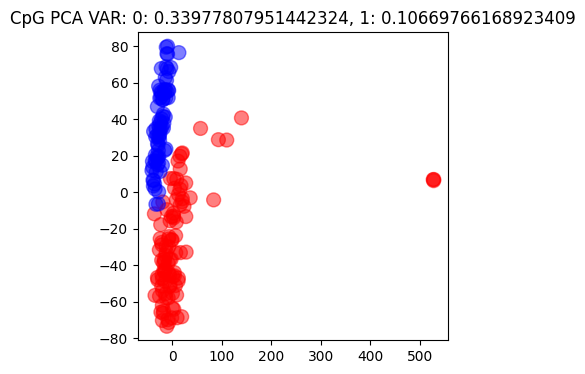

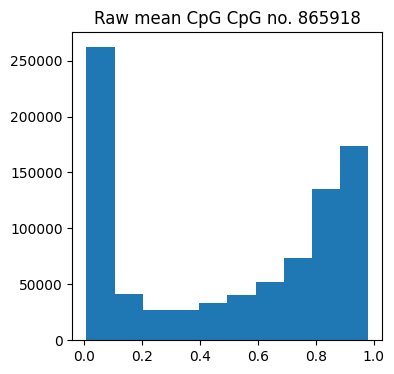

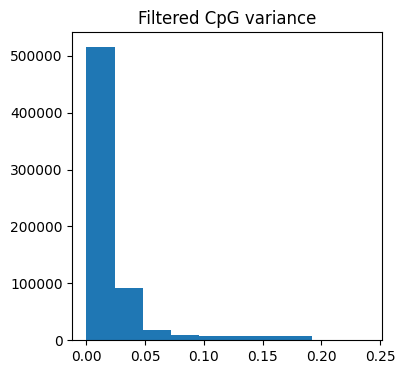

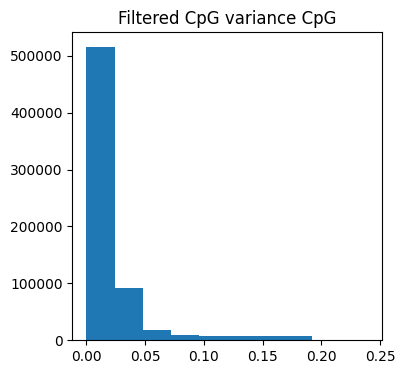

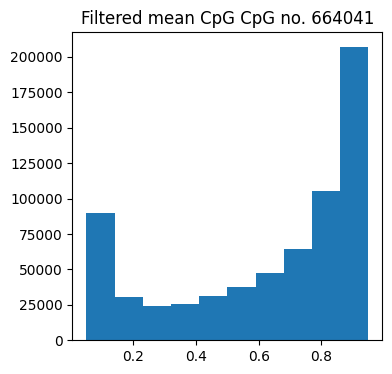

/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


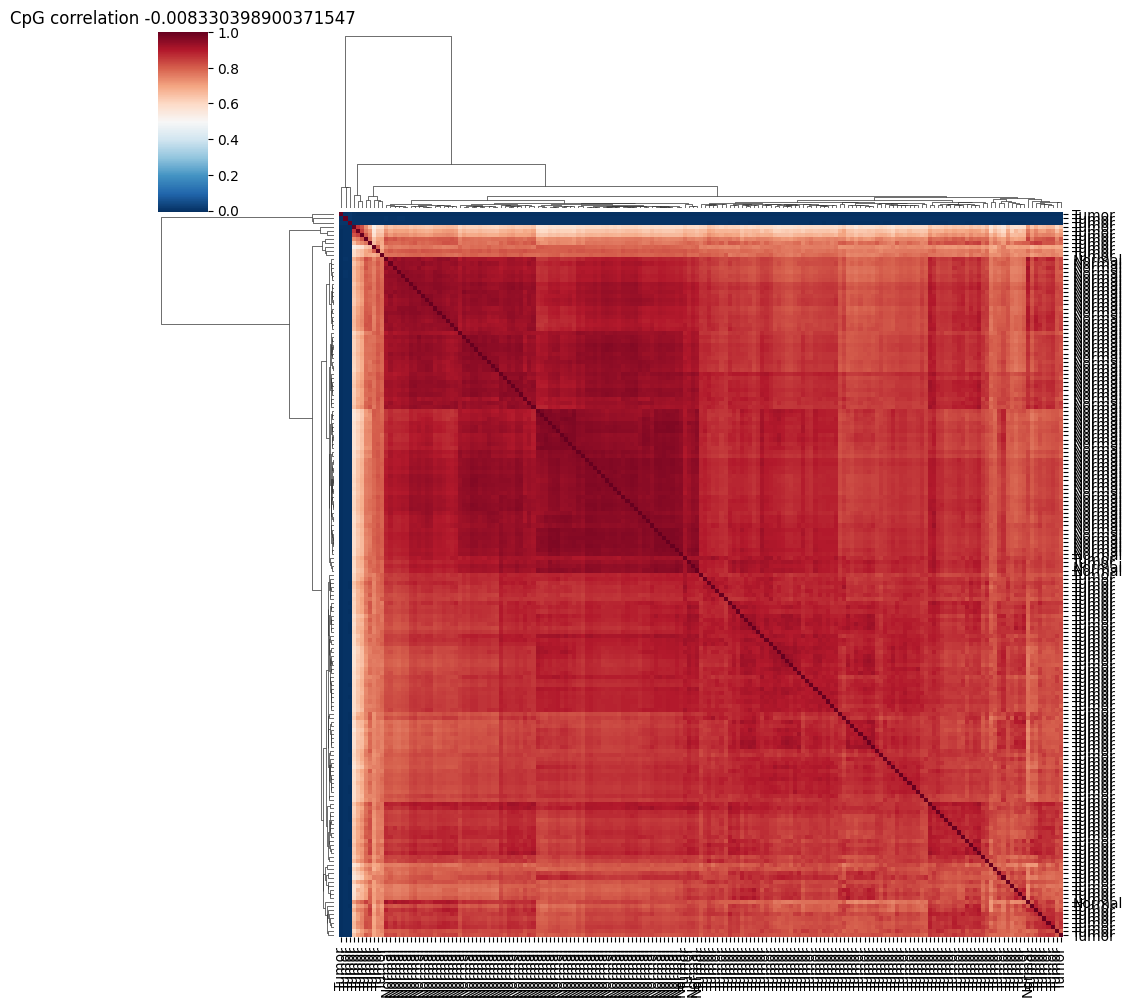

/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


--------------------------------------------------------------------------------
16	patients with avg. correlations less than 50%. Filtering out these samples, and printing cases.	
--------------------------------------------------------------------------------
C3L.01885_Tumor
C3L.01882_Tumor
C3L.01281_Tumor
C3L.01861_Tumor
C3L.01607_Tumor
C3N.01649_Tumor
C3N.00492_Tumor
C3L.00606_Tumor
C3N.01180_Tumor
C3N.00577_Tumor
C3N.01175_Tumor
C3L.00369_Tumor
C3L.01286_Tumor
C3L.00011_Tumor
C3N.00315_Tumor
C3N.01220_Tumor


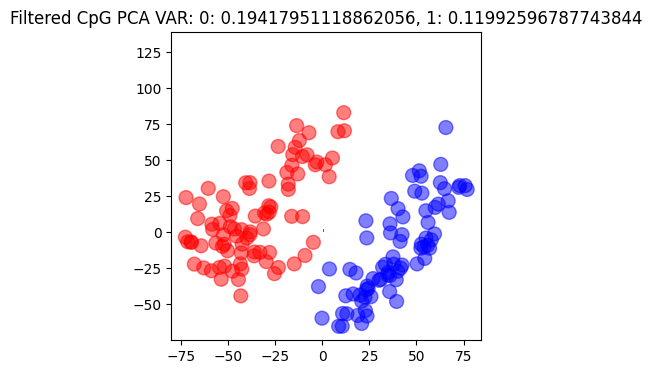

In [31]:
sample_df, cpg_filtered = run_methylation_qc(cpg_samples, cpg_data, 'CpG')

/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


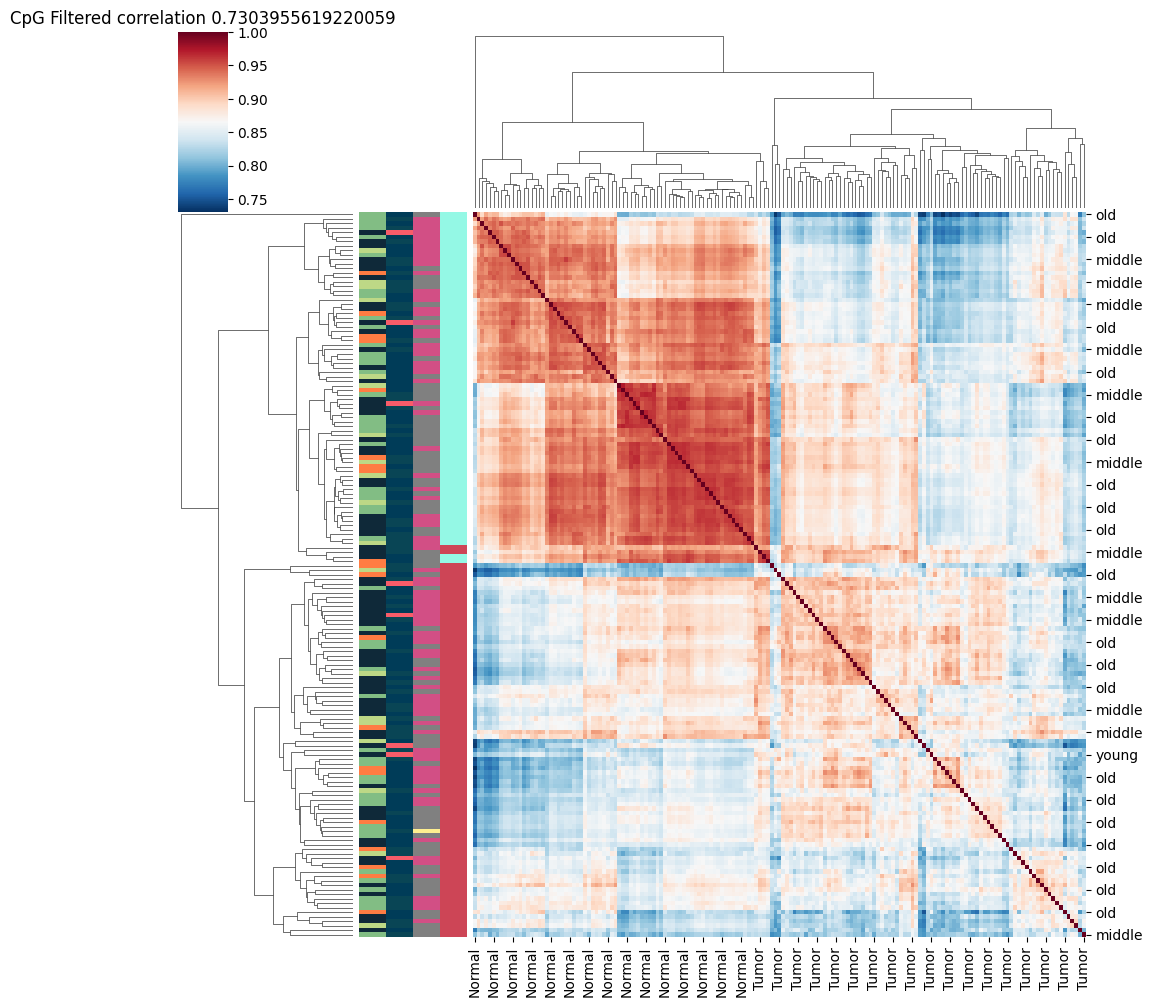

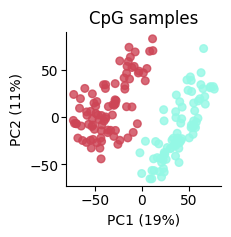

In [32]:
plot_figure1(cpg_filtered, sample_df, 'CpG') # CpG analysis

--------------------------------------------------------------------------------
                            RNA	Normal	73	Tumor	102	                            
--------------------------------------------------------------------------------
Number of Genes prior to filtering:  60660


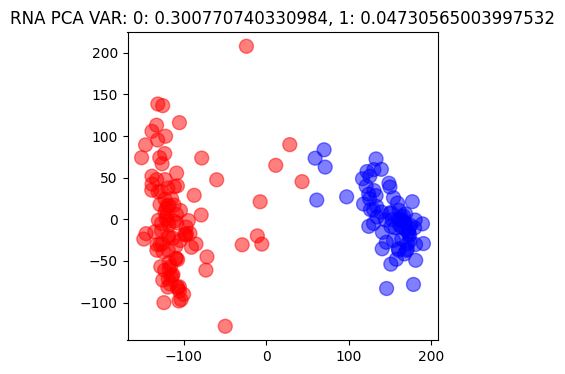

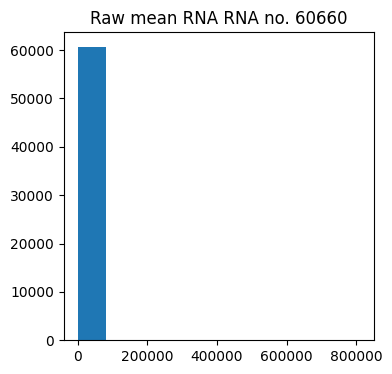

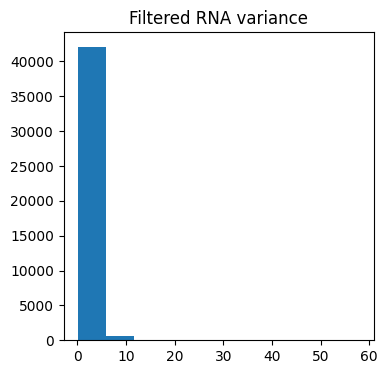

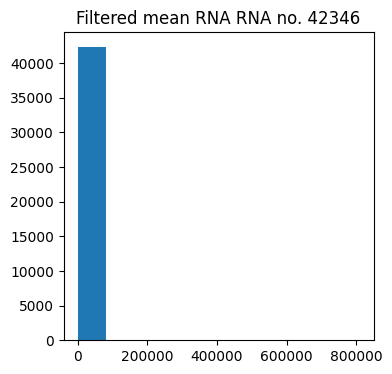

/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


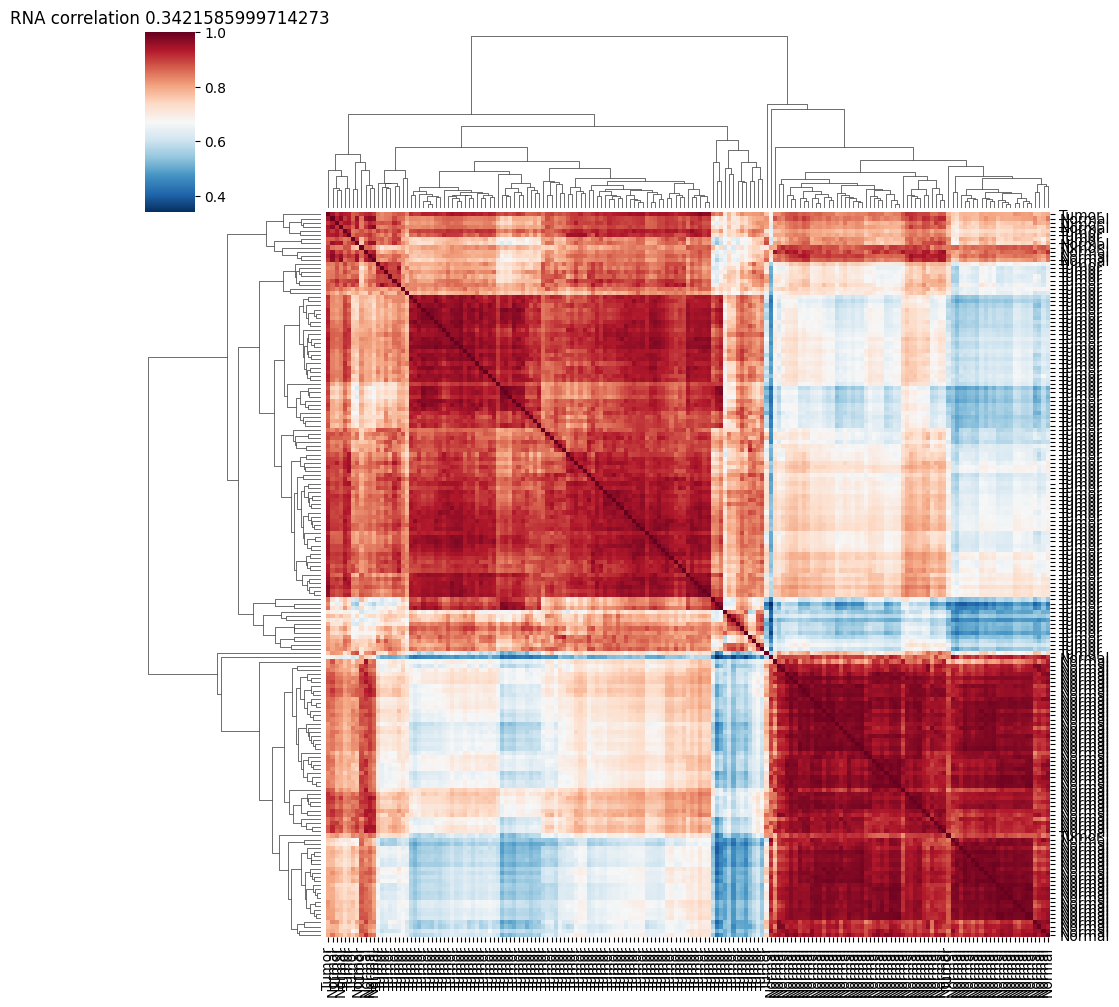

/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


--------------------------------------------------------------------------------
7	patients with avg. correlations less than 50%. Filtering out these samples, and printing cases.	
--------------------------------------------------------------------------------
C3N.00315_Tumor
C3L.00448_Normal
C3N.01200_Tumor
C3L.01553_Tumor
C3N.00435_Tumor
C3N.00492_Tumor
C3N.00577_Tumor


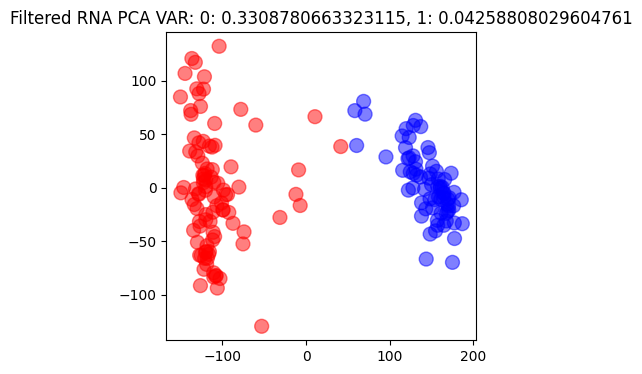

In [33]:
rna_sample_df, rna_filtered = run_RNA_qc(rna_samples, rna_data, 'RNA')

/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


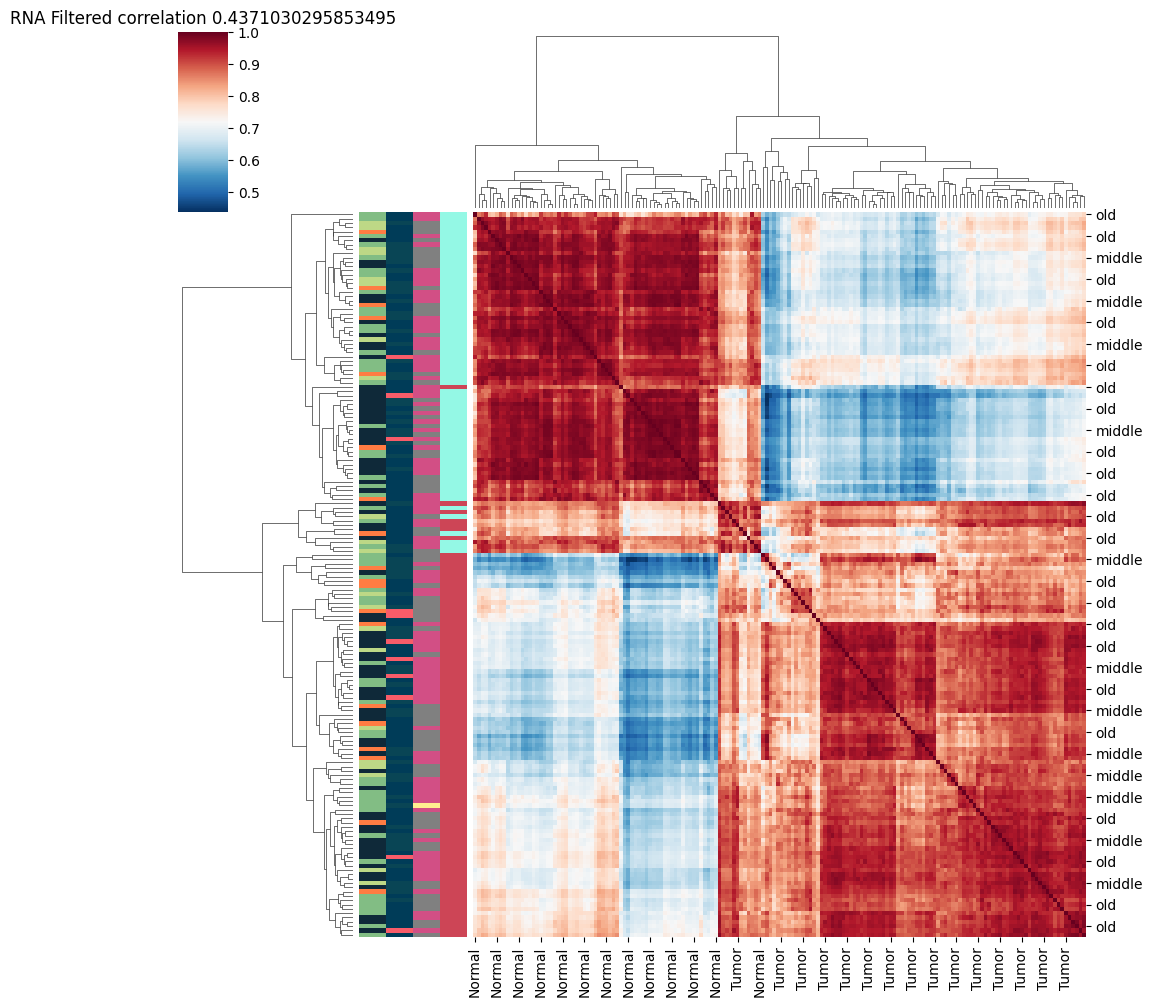

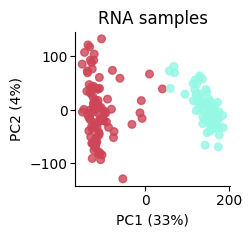

In [34]:
plot_figure1(rna_filtered, rna_sample_df, 'RNA', True) 

--------------------------------------------------------------------------------
                          protein	Normal	79	Tumor	106	                          
--------------------------------------------------------------------------------
Number of Genes prior to filtering:  9964


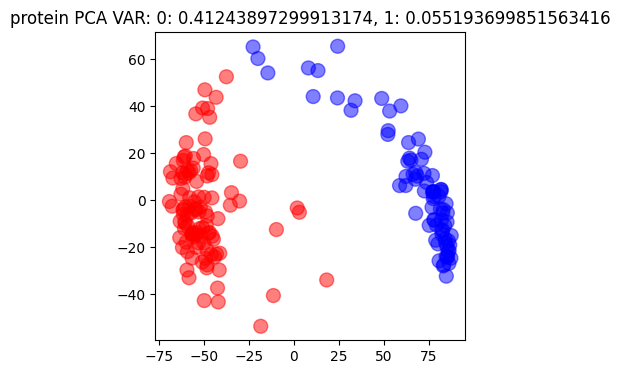

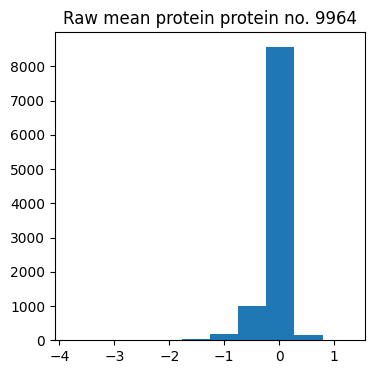

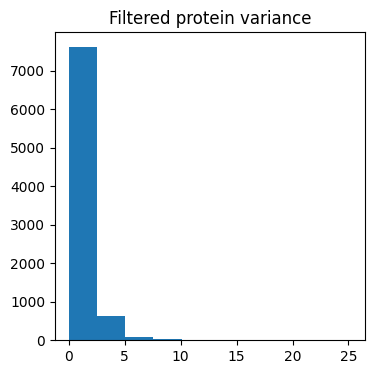

8405


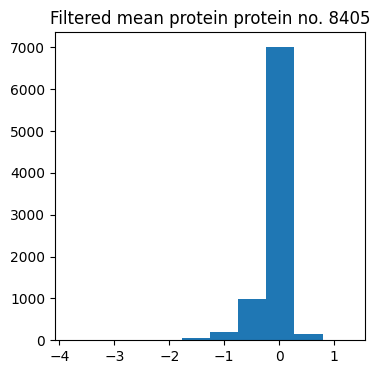

/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


--------------------------------------------------------------------------------
0	patients with avg. correlations less than 50%. Filtering out these samples, and printing cases.	
--------------------------------------------------------------------------------



/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


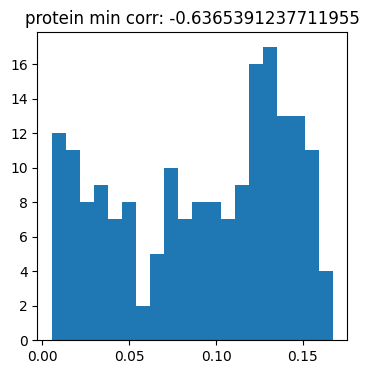

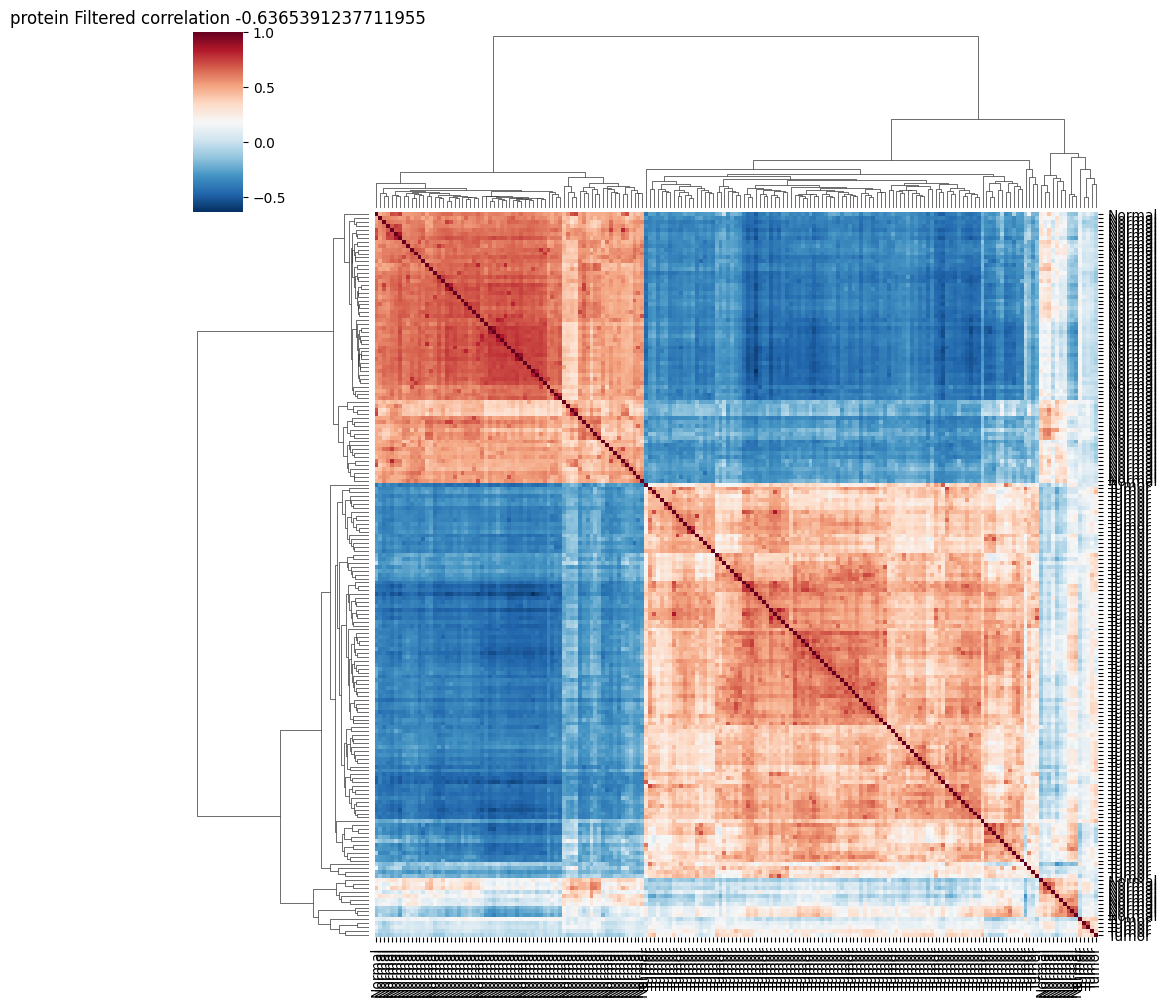

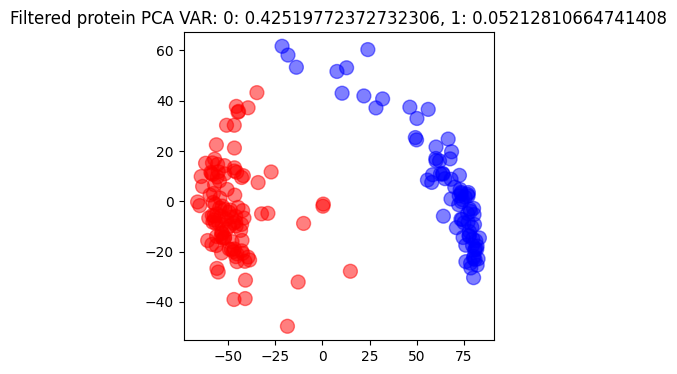

/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/ariane/opt/miniconda3/envs/sircle_feb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


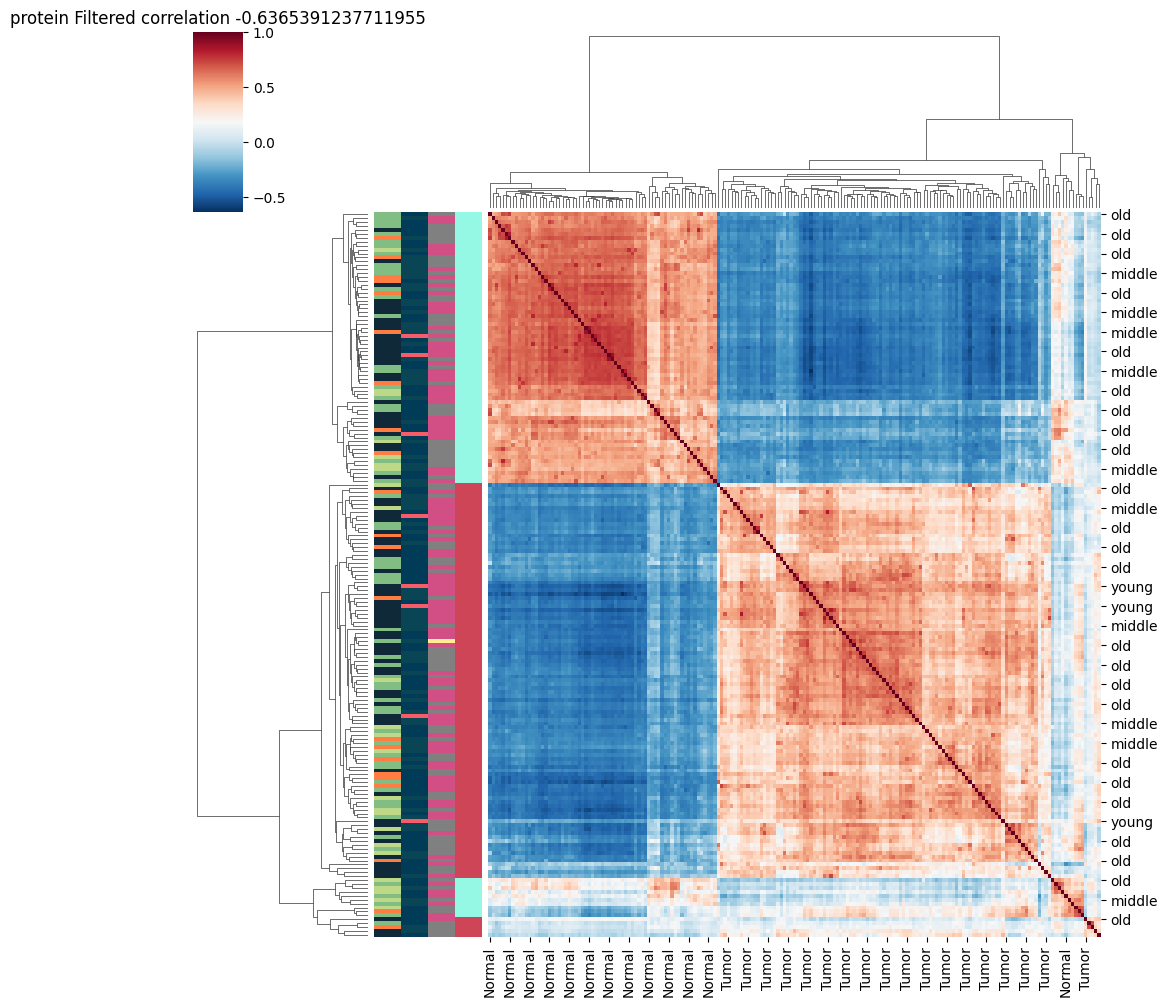

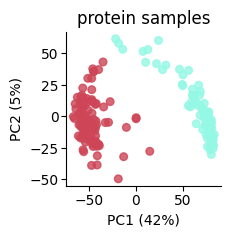

In [103]:
protein_sample_df, protein_filtered = run_protein_qc(protein_samples, protein_data, 'protein')
plot_figure1(protein_filtered, protein_sample_df, 'protein') 

In [106]:
protein_filtered

,gene_name,C3L.01287_Normal,C3L.00561_Normal,C3L.00561_Tumor,C3L.01287_Tumor,C3L.01603_Tumor,C3N.01524_Tumor,C3N.01524_Normal,C3L.01603_Normal,C3L.00359_Tumor,...,C3N.00314_Tumor,C3N.00380_Tumor,C3N.00310_Normal,C3N.00390_Normal,C3N.00312_Tumor,C3N.00494_Tumor,C3N.00390_Tumor,C3N.00312_Normal,C3N.00494_Normal,C3N.00310_Tumor
9963,ZZZ3,0.349510,0.971173,0.278755,0.511292,1.407767,0.383880,0.032974,0.997120,-0.481113,...,0.277106,0.452468,0.436331,0.412133,1.006421,1.074942,0.662748,0.186101,0.569151,0.767589
9962,ZZEF1,0.618882,0.121737,0.379582,0.098328,0.219372,0.499627,0.092100,0.348176,0.484052,...,0.354405,0.428432,0.049082,0.430447,0.117262,-0.123970,-0.321489,0.351691,-0.071489,0.301010
9961,ZYX,-0.504252,-0.094684,0.606810,0.627744,0.602295,0.462694,1.346459,-0.756774,-0.981595,...,0.536886,1.104591,-0.081478,1.032255,0.680305,-0.006626,0.960180,-0.184899,0.576467,0.120651
9960,ZYG11B,-0.033159,0.002073,0.192888,-0.100094,0.086554,0.764285,-0.290071,0.332066,0.838863,...,0.651291,1.426434,0.091772,0.153124,-0.077153,0.478650,-0.207081,0.260334,0.086554,0.139500
9959,ZXDC,0.350151,0.313122,0.137582,-0.291493,0.299916,-0.336058,0.746399,0.561560,-0.170342,...,-0.180909,0.842884,0.166282,0.256057,0.349831,0.796311,0.421929,0.564358,0.039456,0.697174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,AACS,0.895613,0.390762,1.199118,1.464475,0.024645,0.774864,-0.692046,0.335278,0.115359,...,-0.651664,0.091048,0.474799,0.445588,-0.700347,-0.886967,-0.711950,0.389571,0.468282,-0.546067
3,AAAS,0.276354,-0.132548,0.218030,0.695334,-0.281305,-0.120158,0.171536,-0.024335,-0.072927,...,0.516300,0.504216,-0.415263,-0.250285,0.592123,0.401282,0.111218,-0.115058,-0.342036,0.209655
2,A2M,-1.957698,-2.625471,-1.411758,-0.057695,1.666974,1.286902,-0.429035,-0.562827,0.140499,...,-0.122144,0.899461,1.265185,-1.351688,-0.754093,1.845770,0.022048,-1.168581,1.425365,1.484274
1,A1CF,0.944627,1.261316,-0.382622,0.661380,0.055384,-0.233816,-2.193702,1.362645,-1.983246,...,-0.264139,-1.654889,0.236086,0.507999,1.037156,2.306384,-0.255662,1.220208,0.469696,-0.116121


## 2. Differential Analysis (R)

1. Perform DE, DA, and dCpG analysis for each of the datasets.



In [36]:
#!pip install rpy2

In [37]:
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

In [112]:
%%R 

library(DESeq2)
library(edgeR)


pairedPatientDE <- function(data_file, sample_file, output_file, paired=FALSE) {
  cat(paste("Differential Expression analysis for: \n", data_file, "\n"))
  
  counts <- read.csv(data_file, header = TRUE, sep = ",")
  rownames(counts) <- counts$gene_id
  
  experimental_design <- read.csv(sample_file)
  other_info <- counts[, c('gene_name', 'gene_id')] # Keep the metadata info
  rownames(other_info) <- rownames(counts)
  # Let's make sure our count data is in matrix format and is only the numeric columns i.e. everything but the genes
  count_matrix <- as.matrix(counts[,experimental_design$FullLabel])
  
  count_matrix[is.na(count_matrix)] = 0
  # We now set the row names to be the gene IDs
  rownames(count_matrix) <- rownames(counts) 
  
  # Separate out each of the sample names to be the different experiment conditions
  condition_id <- as.factor(experimental_design$CondID)
  case_id <- as.factor(experimental_design$SafeCases)
  
  # Before getting the means we want to normalise the counts (i.e. so our mean isn't stupidly big)
  dge <- DGEList(counts=count_matrix)
  dge <- calcNormFactors(dge, method="TMM")
  tmm <- cpm(dge)
  
  sample_df = data.frame(case_id = case_id, condition_id=condition_id)
  if (paired == TRUE) {
    dds_mat <- DESeqDataSetFromMatrix(countData = count_matrix,
                                      colData = sample_df,
                                      design = ~case_id + condition_id) # Have patient case as a factor (i.e. a batch correction)
    
  } else {
    dds_mat <- DESeqDataSetFromMatrix(countData = count_matrix,
                                      colData = sample_df,
                                      design = ~condition_id) # Just do on condition
    
  }
  
  dds <- estimateSizeFactors(dds_mat)
  
  num_samples_meeting_criteria <- 4  # be strict and enforce that at least half the samples need to meet the criteria (i.e. one full condition)
  num_counts_in_gene <- 10  # They need at least 10 counts
  
  keep <- rowSums(counts(dds_mat) >= num_counts_in_gene) >= num_samples_meeting_criteria
  dds <- dds_mat[keep,] # Only keep the rows with this criteria
  # Now we want to also filter out our other info using the same filter
  other_info_filtered <- other_info[keep,]
  counts_filtered <- counts[keep,]
  tmm_filtered <- tmm[keep, ]
  
  # Log2 the TMM counts for better variance & mean estimation.
  tmm_filtered <- log2(tmm_filtered + 1)
  # Let's print the number of rows
  cat(paste("Dataset dimensions: ", nrow(dds), ncol(dds), "\n"))
  # Run DEseq2
  dds <- DESeq(dds)
  resultsNames(dds)
  # Build results table
  res <- results(dds, independentFiltering=FALSE)
  other_info_filtered <- other_info_filtered[rownames(res), c('gene_name', 'gene_id')]
  
  # Ensure ordering is correct 
  tmm_filtered <- tmm_filtered[rownames(res), colnames(tmm_filtered)]
  other_info_filtered$logFC_rna <- res$log2FoldChange
  other_info_filtered$stat_rna <- res$stat
  other_info_filtered$pvalue_rna <- res$pvalue
  other_info_filtered$padj_rna <- res$padj
  other_info_filtered$lfcSE_rna <- res$lfcSE
  other_info_filtered$baseMean_rna <- res$baseMean
  other_info_filtered$var_rna <- matrixStats::rowVars(as.matrix(tmm_filtered))
  
  # Add in mean info
  all_rna_df <- cbind(other_info_filtered, tmm_filtered)
  
  write.csv(all_rna_df, file = output_file)
  return(all_rna_df)
}

pairedPatientDA <- function(data_file, sample_file, output_file, gene='Gene', FullLabel='FullLabel', CondId='CondID', CaseId='SafeCases', 
                            paired=FALSE) {
  cat(paste("Differential Abundence analysis for: \n", data_file, "\n"))
  # Do protein analysis on the stage 4 sample
  prot_data <- read.csv(data_file)
  gene_names <- prot_data[[gene]]
  experimental_design <- read.csv(sample_file)
  data_columns <- experimental_design[[FullLabel]] # get LFQ column numbers
  
  prot_data_mat <- prot_data[, data_columns]
  prot_data_mat[is.na(prot_data_mat)] <- 0
  
  rownames(prot_data_mat) <- gene_names
  rownames(prot_data) <- gene_names
  
  # Get the column of interest from the experimental design
  cond <- as.factor(experimental_design[[CondId]])
  case_id <- as.factor(experimental_design[[CaseId]])
  
  if (paired == TRUE) {
    design <- model.matrix(~case_id + cond) # We want to perform it on each patient (i.e. since we have matched samples)
  } else {
    design <- model.matrix(~cond) # We didn't have matching patient info
  }
  # Limma is good for detecting differentially abundent proteins
  fit <- lmFit(prot_data_mat, design)
  fit2 <- eBayes(fit, robust=TRUE) # Use robust:  https://www.biostars.org/p/496806/, https://support.bioconductor.org/p/118495/
  
  # Keep in mind the condition of interest (tumour vs normal) is always the final column in the design
  fit2_adj <- topTable(fit2, coef=length(colnames(design)), adjust="fdr", sort.by="none", number=1000000) 
  
  # Create the dataframe to return
  all_prot_df <- prot_data[rownames(fit2_adj), colnames(prot_data)]
  prot_data_mat <- prot_data_mat[rownames(fit2_adj), colnames(prot_data_mat)]
  # Add in the statistics from the DA analysis
  all_prot_df$logFC_protein <- fit2_adj$logFC
  all_prot_df$stat_protein <- fit2_adj$t
  all_prot_df$pvalue_protein <- fit2_adj$P.Value
  all_prot_df$padj_protein <- fit2_adj$adj.P.Val
  all_prot_df$B_protein <- fit2_adj$B
  all_prot_df$mean_protein <- fit2_adj$AveExpr
  
  write.csv(all_prot_df, output_file, row.names = FALSE)
  return(all_prot_df)
}

library(DMRcate)
library(limma)
library(edgeR)
#library("regRCPqn") # https://github.com/regRCPqn/regRCPqn install using devtools

#https://rdrr.io/bioc/lumi/src/R/methylation_preprocessing.R
# convert beta-value to m-value
beta2m <- function(beta) {
  m <- log2(beta/(1-beta))
  return(m)
}

# convert m-value to beta-value 
m2beta <- function(m) {
  beta <- 2^m/(2^m + 1)
  return(beta)
}

pairedPatientDMC <- function(data_file, sample_file, output_file, label, array_type='EPIC', project_dir='', paired=FALSE) {
  
  cat(paste("Differential Methylation analysis for: \n", data_file, "\n"))
  
  #### Import data ####
  cpg_raw <- read.csv(data_file, header = TRUE, sep = ",")
  sample_df <- read.csv(sample_file)
  
  #### Change rownames ####
  rowNames <- unlist(cpg_raw['id'])
  cpg_data <- cpg_raw[, sample_df$FullLabel]
  rownames(cpg_data) <- rowNames
  rownames(cpg_raw) <- rowNames
  #### QC/Filtering
  # First remove all NA values
  cpg_data[is.na(cpg_data)] <- 0
  summary(cpg_data)
  
  # Convert data to a matrix & plot the means for the rows
  cpg_data_m <- as.matrix(cpg_data)
  row_means_data <- rowMeans(cpg_data_m)
  #hist(row_means_data)
  #nrow(cpg_data_m)
  
  # Remove rows with a very small amount of overall DNA methylation
  cpg_data_filtered <- cpg_data_m[row_means_data > 0.05, ]
  cpg_raw_filtered <- cpg_raw[row_means_data > 0.05, ] # Make sure we apply the same filter to our CpG names etc
  nrow(cpg_data_filtered)
  row_means_data <- rowMeans(cpg_data_filtered)
  # hist(row_means_data)
  
  # Remove rows with overly high DNA methylation
  cpg_data_filtered <- cpg_data_filtered[row_means_data < 0.95, ]
  cpg_raw_filtered <- cpg_raw_filtered[row_means_data < 0.95, ] # Make sure we apply the same filter to our CpG names etc
  
  nrow(cpg_data_filtered)
  
  # The function model.matrix is used to generate the design matrix
  cases <- as.factor(sample_df$SafeCases)
  cond_id <- as.factor(sample_df$CondID)
  
  if (paired == FALSE) {
    design = model.matrix(~cond_id)  # Can't do paired in DNA methylation
  } else {
    design = model.matrix(~cases + cond_id) # This way we're actually using the TCGA or the CPTAC as the batch
  }
  
  # Before running limma we want to do two steps, (following the steps of Miss Methyl)
  # 1) convert to M values 
  # 2) perform limma
  # References: 
  # https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-11-587
  # https://bioconductor.org/packages/release/bioc/vignettes/missMethyl/inst/doc/missMethyl.html 
  # Add a very small amount so that if we have 0's we don't get an issue with NAs and log2
  cpg_data_M_filtered <- cpg_data_filtered #log2((cpg_data_filtered + 0.000001) /(1-cpg_data_filtered + 0.000001))
  # Normalise M values using https://github.com/regRCPqn/regRCPqn, https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0229763
  # Install: https://github.com/regRCPqn/regRCPqn
  coef_id <- length(colnames(design))
  fit <- lmFit(cpg_data_M_filtered, design)
  fit2 <- eBayes(fit, robust=TRUE)
  
  # Don't sort it otherwise we won't be able to match the data
  fit2_adj <- as.data.frame(topTable(fit2, coef=coef_id, adjust="fdr", sort.by="none", number=1000000))
  all_cpg_df <- cpg_raw[rownames(fit2_adj), c('Locus')]
  
  # Add in the statistics from the CpG analysis
  all_cpg_df$beta_logFC_meth <- fit2_adj$logFC
  all_cpg_df$beta_stat_meth <- fit2_adj$t
  all_cpg_df$beta_pvalue_meth <- fit2_adj$P.Value
  all_cpg_df$beta_padj_meth <- fit2_adj$adj.P.Val
  all_cpg_df$beta_B_meth <- fit2_adj$B
  all_cpg_df$beta_mean_cpg <- fit2_adj$AveExpr
  all_cpg_df$beta_var_cpg <- matrixStats::rowVars(as.matrix(cpg_data_M_filtered))
  write.csv(fit2_adj, paste0(project_dir, label, "_Beta_DMCLimma.csv"))

  ### Do the DMR comparison on the beta values
  out <- tryCatch(
    expr = {
      myAnnotation <- cpg.annotate(object = cpg_data_M_filtered, datatype = "array", what = "Beta", 
                                   arraytype = c(array_type), 
                                   analysis.type = "differential", design = design, coef = coef_id)
      
      DMRs <- dmrcate(myAnnotation, lambda=1000, C=2)
      
      results.ranges <- extractRanges(DMRs, genome='hg38')
      
      #### Write DMR results and information to a csv file ####
      write.csv(results.ranges, paste0(project_dir, label, "_Beta_DMRcate.csv"))
    },
    error = function(e){
      message('Caught an error!')
      print(e)
    },
    warning = function(w){
      message('Caught an warning!')
      print(w)
    },
    finally = {
      message('All done, quitting.')
    }
  )
  
  # Do the same with the M values 
  cpg_data_M_filtered <- log2(cpg_data_filtered/(1-cpg_data_filtered))

  # Normalise M values using https://github.com/regRCPqn/regRCPqn, https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0229763
  # Install: https://github.com/regRCPqn/regRCPqn
  # cpg_data_M_filtered <- regRCPqn(cpg_data_M_filtered, "", "", save_ref=FALSE) # Normalising data 
  coef_id <- length(colnames(design))
  fit <- lmFit(cpg_data_M_filtered, design)
  fit2 <- eBayes(fit, robust=TRUE)
  fit2_adj <- as.data.frame(topTable(fit2, coef=coef_id, adjust="fdr", sort.by="none", number=1000000))
  
  # Add in the statistics from the CpG analysis
  all_cpg_df$M_logFC_meth <- fit2_adj$logFC
  all_cpg_df$M_betadiff_meth <- (2^fit2_adj$logFC)/(2^fit2_adj$logFC + 1)
  all_cpg_df$M_stat_meth <- fit2_adj$t
  all_cpg_df$M_pvalue_meth <- fit2_adj$P.Value
  all_cpg_df$M_padj_meth <- fit2_adj$adj.P.Val
  all_cpg_df$M_B_meth <- fit2_adj$B
  all_cpg_df$M_mean_cpg <- fit2_adj$AveExpr
  all_cpg_df$M_var_cpg <- matrixStats::rowVars(as.matrix(cpg_data_M_filtered))
  
  write.csv(fit2_adj, paste0(project_dir, label, "_M_DMCLimma.csv"))
  
  ### Do the DMR comparison
  out <- tryCatch(expr = {
    myAnnotation <- cpg.annotate(object = cpg_data_M_filtered, datatype = "array", what = "M", 
                                 arraytype = c(array_type), 
                                 analysis.type = "differential", design = design, coef = coef_id)
    
    DMRs <- dmrcate(myAnnotation, lambda=1000, C=2)
    
    results.ranges <- extractRanges(DMRs, genome='hg38')
    
    #### Write DMR results and information to a csv file ####
    write.csv(results.ranges, paste0(project_dir, label, "_M_DMRcate.csv"))
  },
  error = function(e){
    message('Caught an error!')
    print(e)
  },
  warning = function(w){
    message('Caught an warning!')
    print(w)
  },
  finally = {
    message('All done, quitting.')
  })
  return(all_cpg_df)
}

In [67]:
%%R

# Do differential methylation analysis
project_dir <- '/Users/ariane/Documents/code/sircle_review/ccRCC/data_input/'
project_dir <- '/Users/ariane/Documents/code/sircle_review/ccRCC/DE/'


de <- pairedPatientDE(paste0(project_dir, 'data_RNA.csv'), 
                  paste0(project_dir, 'samples_RNA.csv'), 
                  paste0(output_dir, 'DE_RNA.csv'),
                  paired=FALSE)




Differential Expression analysis for: 
 /Users/ariane/Documents/code/sircle_review/ccRCC/data_input/data_RNA.csv 


R[write to console]: converting counts to integer mode



Dataset dimensions:  38561 168 


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1973 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



In [113]:
%%R
dmc <- pairedPatientDMC(paste0(project_dir, 'data_CpG.csv'), 
                   paste0(project_dir, 'samples_CpG.csv'), 
                   paste0(output_dir, 'DCpG_CpG.csv'), 
                   label='DMeth',
                   project_dir = output_dir,
                   array_type='EPIC', # EPIC for CPTAC
                   paired=FALSE)

Differential Methylation analysis for: 
 /Users/ariane/Documents/code/sircle_review/ccRCC/data_input/data_CpG.csv 


R[write to console]: Your contrast returned 450292 individually significant probes. We recommend the default setting of pcutoff in dmrcate().

R[write to console]: Fitting chr1...

R[write to console]: Fitting chr2...

R[write to console]: Fitting chr3...

R[write to console]: Fitting chr4...

R[write to console]: Fitting chr5...

R[write to console]: Fitting chr6...

R[write to console]: Fitting chr7...

R[write to console]: Fitting chr8...

R[write to console]: Fitting chr9...

R[write to console]: Fitting chr10...

R[write to console]: Fitting chr11...

R[write to console]: Fitting chr12...

R[write to console]: Fitting chr13...

R[write to console]: Fitting chr14...

R[write to console]: Fitting chr15...

R[write to console]: Fitting chr16...

R[write to console]: Fitting chr17...

R[write to console]: Fitting chr18...

R[write to console]: Fitting chr19...

R[write to console]: Fitting chr20...

R[write to console]: Fitting chr21...

R[write to console]: Fitting chr22...

R[write 

  |===================                                                   |  27%
  |                                                                            
  |===================                                                   |  28%
  |                                                                            
  |====================                                                  |  28%
  |                                                                            
  |====================                                                  |  29%
  |                                                                            
  |=====================                                                 |  29%
  |                                                                            
  |=====================                                                 |  30%
  |                                                                            
  |=====================                

  |                                                                            
  |==========================================                            |  60%
  |                                                                            
  |==========================================                            |  61%
  |                                                                            
  |===========================================                           |  61%
  |                                                                            
  |===========================================                           |  62%
  |                                                                            
  |============================================                          |  62%
  |                                                                            
  |============================================                          |  63%
  |                                     

  |================================================================      |  92%
  |                                                                            
  |=================================================================     |  92%
  |                                                                            
  |=================================================================     |  93%
  |                                                                            
  |==================================================================    |  94%
  |                                                                            
  |==================================================================    |  95%
  |                                                                            
  |===================================================================   |  95%
  |                                                                            
  |=====================================

R[write to console]: snapshotDate(): 2021-05-18

R[write to console]: Caught an warning!



<simpleWarning: package 'AnnotationHub' was built under R version 4.1.1>


R[write to console]: All done, quitting.

R[write to console]: Your contrast returned 450292 individually significant probes. We recommend the default setting of pcutoff in dmrcate().

R[write to console]: Fitting chr1...

R[write to console]: Fitting chr2...

R[write to console]: Fitting chr3...

R[write to console]: Fitting chr4...

R[write to console]: Fitting chr5...

R[write to console]: Fitting chr6...

R[write to console]: Fitting chr7...

R[write to console]: Fitting chr8...

R[write to console]: Fitting chr9...

R[write to console]: Fitting chr10...

R[write to console]: Fitting chr11...

R[write to console]: Fitting chr12...

R[write to console]: Fitting chr13...

R[write to console]: Fitting chr14...

R[write to console]: Fitting chr15...

R[write to console]: Fitting chr16...

R[write to console]: Fitting chr17...

R[write to console]: Fitting chr18...

R[write to console]: Fitting chr19...

R[write to console]: Fitting chr20...

R[write to console]: Fitting chr21...

R[wri

<simpleWarning: package 'AnnotationHub' was built under R version 4.1.1>


R[write to console]: All done, quitting.



In [111]:
%%R
da <- pairedPatientDA(paste0(project_dir, 'data_Protein.csv'), 
                  paste0(project_dir, 'samples_Protein.csv'), 
                  paste0(output_dir, 'DA_Protein.csv'), 
                  gene='gene_name', FullLabel='FullLabel', CondId='CondID', CaseId='SafeCases', 
                  paired=FALSE)


Differential Abundence analysis for: 
 /Users/ariane/Documents/code/sircle_review/ccRCC/data_input/data_Protein.csv 


## 3. SiRCle 

a. Summarise differential CpGs to genes.  
b. Plot volcano of each differential analysis.  
c. Run SiRCle using the DE/DA/dCpG results.  


### 3.a. Summarise differential CpGs to genes.  


In [ ]:
def filter_methylation_data_by_genes(cpg_df, gene_id, p_val, logfc):
    cpg_df_grped = cpg_df.groupby(gene_id)
    rows = []
    num_cpgs = []
    for cpg in cpg_df_grped:
        cpg = cpg[1]
        cpg = cpg[cpg[p_val] < 0.05]
        num_cpgs.append(len(cpg))
        if len(cpg) > 0:
            if len(cpg) < 3:
                add_row = True
            else:
                pos_cpg = cpg[cpg[logfc] > 0]
                neg_cpg = cpg[cpg[logfc] < 0]
                num_pos = len(pos_cpg)
                num_neg = len(neg_cpg)
                add_row = False
                if num_pos and num_pos/len(cpg) > 0.6:
                    cpg = pos_cpg
                    add_row = True
                elif num_neg and num_neg/len(cpg) > 0.6:
                    cpg = neg_cpg
                    add_row = True
            if add_row:
                max_cpg_idx = None
                max_t_value = 0  # absolute
                idxs = cpg.index
                for i, t in enumerate(cpg[logfc].values):
                    if abs(t) > abs(max_t_value):
                        max_t_value = t
                        max_cpg_idx = i
                rows.append(cpg[cpg.index == idxs[max_cpg_idx]].values[0])
    new_cpg_df = pd.DataFrame(rows, columns=cpg_df.columns)
    u = SciUtil()
    u.dp(['Originally had: ', len(cpg_df_grped), 'genes.\n', 'Filtered DF now has: ', len(new_cpg_df), ' genes.'])
    return new_cpg_df


In [93]:
epic_manifest = pd.read_csv(f'{supp_dir}infinium-methylationepic-v-1-0-b5-manifest-file.csv', comment='#')
epic_manifest.set_index('IlmnID', inplace=True)
epic_manifest

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_3505/3358257652.py:1: DtypeWarning: Columns (2,4,42,47) have mixed types. Specify dtype option on import or set low_memory=False.
  epic_manifest = pd.read_csv('../supps/infinium-methylationepic-v-1-0-b5-manifest-file.csv', comment='#')


,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,Genome_Build,...,Coordinate_36,SNP_ID,SNP_DISTANCE,SNP_MinorAlleleFrequency,Random_Loci,MFG_Change_Flagged,CHR_hg38,Start_hg38,End_hg38,Strand_hg38
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg07881041,cg07881041,85713262,CTACAAATACAACACCCTCAACCCATATTTCATATATTATCTCATT...,NaN,NaN,II,NaN,NaN,CTGCACGCCTACTGCAGGTGCAGCACCCTCAGCCCATGTTTCATGT...,37.0,...,5187016,rs187313142,18,0.000200,NaN,False,chr19,5236004.0,5236006.0,+
cg18478105,cg18478105,46761277,AAATAAATTTCACTCTCAAATCCCAATCTCATACAACAAAACAAAA...,86644198.0,AAATAAATTTCGCTCTCAAATCCCAATCTCGTACGACGAAACGAAA...,I,C,Grn,TCCCGTCTTACGGGATGGATTTCGCTCTCAGGTCCCAGTCTCGTGC...,37.0,...,61318095,rs549944121,5,0.001797,NaN,False,chr20,63216297.0,63216299.0,+
cg23229610,cg23229610,21717843,ATAAAATTCTTTCCTTAAAAAACATTAAAACCAAAATAAACAAAAA...,NaN,NaN,II,NaN,NaN,GTTTCTGGACAGTAAAATTCTTTCCTTGAAGGACATTAGGGCCAAA...,37.0,...,6763712,rs545824288;rs527255711,40;12,0.000200;0.001198,NaN,False,chr1,6781064.0,6781066.0,+
cg03513874,cg03513874,29622133,ACAATAAAATAATAAAATCCCATCACTACTTACCCTCCTTAAATAA...,NaN,NaN,II,NaN,NaN,ATTGTGCCCACCTTGCTGCTGACAGTTAAGCATCACTAAAGTAGGA...,37.0,...,198011711,NaN,NaN,NaN,NaN,False,chr2,197438741.0,197438743.0,-
cg09835024,cg09835024,16745152,AATAAACACCAACCCCAAACCAATCTCACTTTATTAAATTACAAAA...,81631976.0,AATAAACGCCGACCCCGAACCGATCTCGCTTTATTAAATTACAAAA...,I,A,Red,AGCCCCGTCATAGGTGGGCGCCGACCCCGAGCCGATCTCGCTTTAT...,37.0,...,23982561,NaN,NaN,NaN,NaN,False,chrX,24054522.0,24054524.0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71678368,NORM_T,Purple,Norm_T3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72748406,NORM_A,Red,Norm_A23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73635489,NORM_T,Purple,Norm_T35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Join the DCpG file with the epic manifest and then filter the file
# Annotate the gene names to entrez gene IDs using annotation file from HG38
annot = pd.read_csv(f'{supp_dir}hsapiens_gene_ensembl-GRCh38.p13.csv')
annot = annot.dropna(subset=['external_gene_name', 'entrezgene_id'])
annot = annot.drop_duplicates(subset='external_gene_name')
name_to_entrez = dict(zip(annot.external_gene_name, annot.entrezgene_id))

In [92]:
# Set cutoffs for RCM
rna_padj_cutoff = 0.05
prot_padj_cutoff = 0.05
meth_padj_cutoff = 0.05

rna_logfc_cutoff = 0.5
prot_logfc_cutoff = 0.5
meth_diff_cutoff = 0.1

In [ ]:
import itertools
from matplotlib import rcParams

rcm = SciRCM(f'{de_dir}Filtered_DCpG.csv', 
                 f'{de_dir}DE_RNA.csv', 
                 f'{de_dir}DA_protein.csv',  
                 "logFC_rna", "padj_rna", "logFC", 'adj.P.Val', "logFC_protein", "padj_protein",
                 "gene_name", sep=',',
                 rna_padj_cutoff=rna_padj_cutoff, 
                 prot_padj_cutoff=prot_padj_cutoff, 
                 meth_padj_cutoff=meth_padj_cutoff,
                 rna_logfc_cutoff=rna_logfc_cutoff, 
                 prot_logfc_cutoff=prot_logfc_cutoff, 
                 meth_diff_cutoff=meth_diff_cutoff, 
                 output_dir=de_dir,
                 non_coding_genes=['None'],
                 output_filename=sircle_file_name,
                 bg_type = 'P|(M&R)'
             )
rcm.run()
df = rcm.get_df()
df['entrezgene_id'] = [name_to_entrez.get(g) for g in df['gene_name'].values]
df.to_csv(f'../data/sircle_data/{sircle_file_name}', index=False)

reg_label = 'RG2_Changes'
# figure size in inches
rcParams['figure.figsize'] = 3,2
sns.set(rc={'figure.figsize':(3,2)}, style='ticks')
#
colour_map = { 'MDS': '#d8419b', 'MDS_TMDE': '#e585c0', 'MDS_ncRNA': '#d880b4',
               'MDE': '#6aaf44', 'MDE_TMDS': '#0e8e6d', 'MDE_ncRNA': '#9edb77',
               'TMDE': '#fe2323', 'TMDS': '#2952ff',
               'TPDE': '#e68e25', 'TPDE_TMDS': '#844c0f',
                'TPDS': '#462d76', 'TPDS_TMDE': '#9b29b7'}

sns.set_palette("Greys_r")
rcm_labels = ["TMDE", "TMDS", "TPDE_TMDS", "TPDE", "TPDS_TMDE", "TPDS", "MDS_TMDE", "MDE",  "MDE_TMDS", "MDS"]
colours = [colour_map[c] for c in rcm_labels]

g = sns.catplot(data=df, x=reg_label + '_filtered', kind="count", order=rcm_labels, palette=sns.color_palette(colours), 
               height=4)
plt.xticks(rotation=45, ha='right')
plt.title(labels[i])
plt.savefig(f'../figs/Figure4A_barplot_{labels[i]}_TvN.svg')
plt.show()

reg_label = 'RG3_Translation'
g = sns.catplot(data=df, x=reg_label+ '_filtered', kind="count",  order=[c for c in set(df[reg_label].values) if c != 'None'],
               height=4)
plt.xticks(rotation=45, ha='right')
plt.title(labels[i])
plt.savefig(f'../figs/Figure4A_barplot_{labels[i]}_{reg_label}_TvN.svg')
plt.show()

g = sns.catplot(data=df, x=reg_label + '_filtered', kind="count", order=[c for c in set(df[reg_label].values) if c != 'None'])
plt.xticks(rotation=45, ha='right')
plt.title(labels[i])
plt.savefig(f'../figs/Figure4A_barplot_{labels[i]}_{reg_label}_TvN.svg')
plt.show()

## 4. Over representation analysis (R)

1. Run ORA on each of the SiRCle clusters. 

In [ ]:
%%R

GSEA_file_dir <- '../data/raw_downloads/supps/GSEA/'
figure_dir <- '../figures/'
input_data_dir <- '../data/sircle/F1_DE_input_TvN/'
output_data_dir <- '../data/sircle/F2_DE_output_TvN/'
 
#Import the pathways:
KEGG <- read.csv(file.path(GSEA_file_dir,  "c2.cp.kegg.v6.2.symbols.csv"))
Reactome <- read.csv(file.path(GSEA_file_dir,  "c2.cp.reactome.v6.2.symbols.csv"))
Biocarta <- read.csv(file.path(GSEA_file_dir, "c2.cp.biocarta.v6.2.symbols.csv"))
Hallmarks <- read.csv(file.path(GSEA_file_dir,  "h.all.v6.2.symbols.csv"))
GO_BP <- read.csv(file.path(GSEA_file_dir, "c5.go.bp.v7.2.symbols.csv"))
GO_CC <- read.csv(file.path(GSEA_file_dir, "c5.go.cc.v7.2.symbols.csv"))
GO_MF <- read.csv(file.path(GSEA_file_dir, "c5.go.mf.v7.2.symbols.csv"))
Metabolic <- read.csv(file.path(GSEA_file_dir, "41467_2016_BFncomms13041_MOESM340_ESM.csv"))
Correction <- read.csv(file.path(GSEA_file_dir, "41467_2016_BFncomms13041_MOESM340_ESM.csv"))

#Run the GSEA analysis
##1."KEGG", "Reactome", "Biocarta", "Hallmarks"
pathways <- rbind(KEGG, Reactome, Biocarta, Hallmarks)
pathway_list <- list()
for (pathway in unique(pathways$term)) {
  pathway_list[[pathway]] <- as.character(pathways[pathways$term == pathway, 1])
}

sircleORAHuman <- function(filename, entrezId, title, regLabels="RegulatoryLabels", emptyRegLabel="", fileType="pdf",
                           minGSSize=10, qvalueCutoff=0.2, pvalueCutoff=0.05, showCatagory=30, outputFolder='') {
  ## ------------ Setup and installs ----------- ##
  packages <- c("org.Hs.eg.db", "clusterProfiler", "svglite", "enrichplot")
  install.packages(setdiff(packages, rownames(installed.packages())))
  library(org.Hs.eg.db)
  library(clusterProfiler)
  library(svglite)
  library(enrichplot)
  ## ------------ Run ----------- ##
  # open the data
  df <- read.csv(filename)
  allGenes <- as.character(df[[entrezId]]) #
  clusterGenes <- subset(df, ! df[[regLabels]] == emptyRegLabel)
  grps_labels <- unlist(unique(clusterGenes[regLabels]))
  for(g in grps_labels) {
    grpGenes <- subset(df, df[[regLabels]] == g)
    print(g)
    print(dim(grpGenes))
    clusterGo <- enrichGO(gene = as.character(grpGenes[[entrezId]]),
                          universe = allGenes,
                          keyType = "ENTREZID",
                          OrgDb = org.Hs.eg.db,
                          ont = "ALL",
                          pAdjustMethod = "BH",
                          qvalueCutoff = 1.0,
                          pvalueCutoff = 1.0,
                          minGSSize = minGSSize,
                          readable = TRUE)
    # We have a cutoff of all of them, and then only visualise the ones that the user wants...

    clusterGoSummary <- data.frame(clusterGo)
    write.csv(clusterGoSummary, paste(outputFolder, 'ClusterGoSummary_', g, title, '.csv', sep=""))#Export the ORA results as .csv

    if (!(dim(clusterGoSummary)[1] == 0)) {#exclude df's that have no observations
      Dotplot <- dotplot(clusterGo, showCategory=showCatagory) +
        ggtitle(paste("Dotplot ", g, sep=""))
      ggsave(file=paste(outputFolder, "SiRCle-ORA_Dotplot_Human_", g, title, ".", fileType, sep=""), plot=Dotplot, width=10, height=8)
      x2 <- pairwise_termsim(clusterGo)

      Emapplot <- emapplot(x2, pie_scale=1.5, layout = "nicely")+
        ggtitle(paste("Emapplot ", g, sep=""))
      ggsave(file=paste(outputFolder, "SiRCle-ORA_Emapplot_Human_", g, title, ".", fileType, sep="" ), plot=Emapplot, width=10, height=8)

      Heatplot <- heatplot(clusterGo,showCategory=showCatagory) +
        theme(axis.text.x =element_text(size=5), axis.text.y =element_text(size=8,face="bold"), axis.title=element_text(size=12,face="bold"))+
        ggtitle(paste("Heatplot ", g, sep=""))
      ggsave(file=paste(outputFolder, "SiRCle-ORA_Heatplot_Human_", g,title,  ".", fileType, sep="" ), plot=Heatplot, width=10, height=8)

    }
  }
}

sircleFileName <- paste0('../data/sircle/F3_regulatory_clustering/review/RCM_PandR_filter.csv')
regLabel <- 'RG2_Changes'
test_title <- '_PandR'
sircleORAHuman(sircleFileName, "entrezgene_id", test_title, regLabel, emptyRegLabel="None", minGSSize=10, qvalueCutoff=0.1, outputFolder='../data/sircle/F3_regulatory_clustering/review/')